In [1]:
! pip install matplotlib,tensorflow,numpy

# Get the data

In [2]:
# Login to Kaggle
# Download the dataset
# https://www.kaggle.com/datasets/hasnainjaved/melanoma-skin-cancer-dataset-of-10000-images/data
# unzip the dataset

# FOLDER STRUCTURE:
# /melanoma_cancer_dataset
#     /train
#        /benign
#        /malignant
#     /test
#        /benign
#        /malignant

# imports

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

# Transfer learning from a pretrained model

In [16]:
train_dir  = 'melanoma_cancer_dataset/train'
test_dir  = 'melanoma_cancer_dataset/test'

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)


Found 9605 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


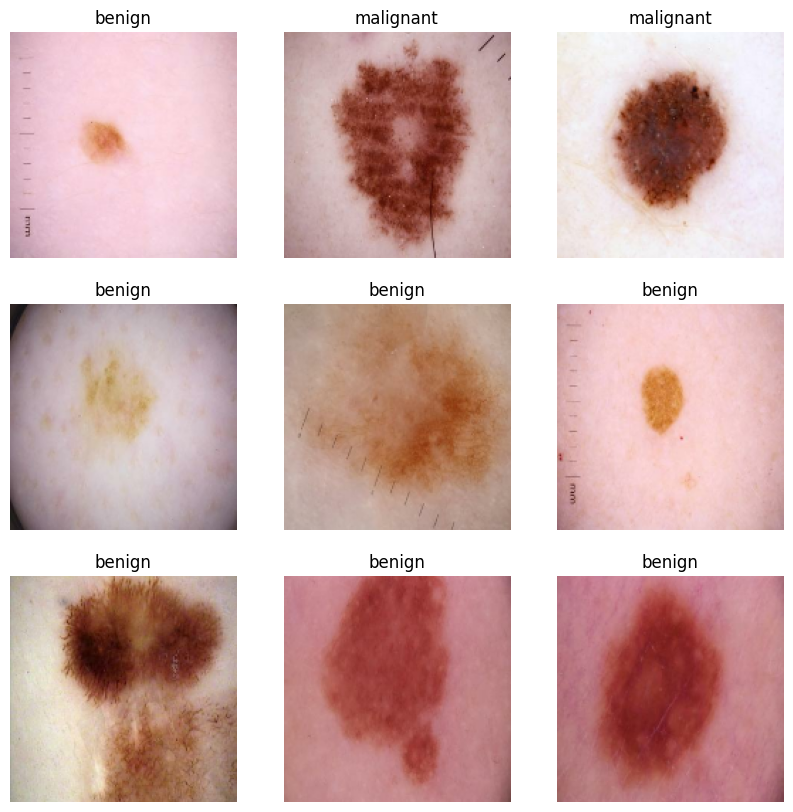

In [17]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [18]:
train_batches = tf.data.experimental.cardinality(train_dataset)
validation_dataset = train_dataset.take(train_batches // 5)
train_dataset = train_dataset.skip(train_batches // 5)

print('Number of training batches: %d' % tf.data.experimental.cardinality(train_dataset))
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of training batches: 241
Number of validation batches: 60
Number of test batches: 32


In [19]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)


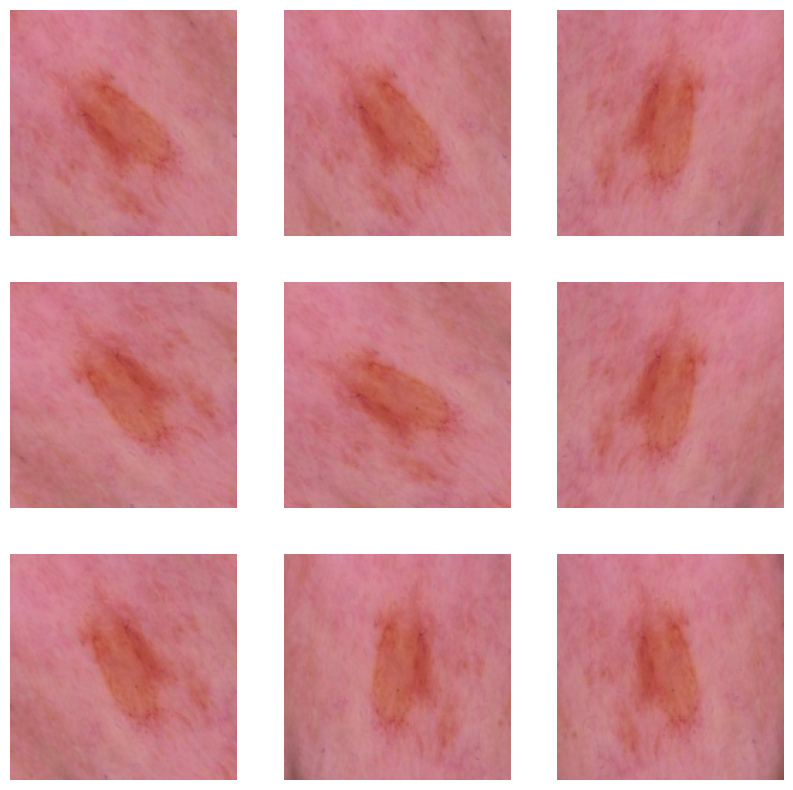

In [20]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')



In [21]:
# Model input shape
IMG_SHAPE = IMG_SIZE + (3,)
# Download the MobileNetV2 model
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
# get the preprocess_input function of the base model
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
# Freeze the base model
base_model.trainable = False

In [25]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(inputs, outputs)
len(model.trainable_variables)


2

In [26]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv_3 (TFOpLam  (None, 160, 160, 3)       0         
 bda)                                                            
                                                                 
 tf.math.subtract_3 (TFOpLa  (None, 160, 160, 3)       0         
 mbda)                                                           
                                                                 
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                           

In [27]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy','AUC'])

In [28]:
epochs = 10

history = model.fit(train_dataset,
                    epochs=epochs,
                    validation_data=validation_dataset)


Epoch 1/10


241/241 [==============================] - 78s 311ms/step - loss: 0.5728 - accuracy: 0.7024 - auc: 0.7680 - val_loss: 0.4471 - val_accuracy: 0.8000 - val_auc: 0.8782
Epoch 2/10
241/241 [==============================] - 71s 292ms/step - loss: 0.4388 - accuracy: 0.7940 - auc: 0.8750 - val_loss: 0.3867 - val_accuracy: 0.8328 - val_auc: 0.9118
Epoch 3/10
241/241 [==============================] - 84s 348ms/step - loss: 0.3941 - accuracy: 0.8208 - auc: 0.9015 - val_loss: 0.3546 - val_accuracy: 0.8469 - val_auc: 0.9254
Epoch 4/10
241/241 [==============================] - 83s 342ms/step - loss: 0.3674 - accuracy: 0.8342 - auc: 0.9153 - val_loss: 0.3444 - val_accuracy: 0.8479 - val_auc: 0.9282
Epoch 5/10
241/241 [==============================] - 91s 376ms/step - loss: 0.3613 - accuracy: 0.8372 - auc: 0.9180 - val_loss: 0.3302 - val_accuracy: 0.8557 - val_auc: 0.9335
Epoch 6/10
241/241 [==============================] - 89s 366ms/step - loss: 0.3484 - accuracy: 0.8433 - auc: 0.9236 - val_los

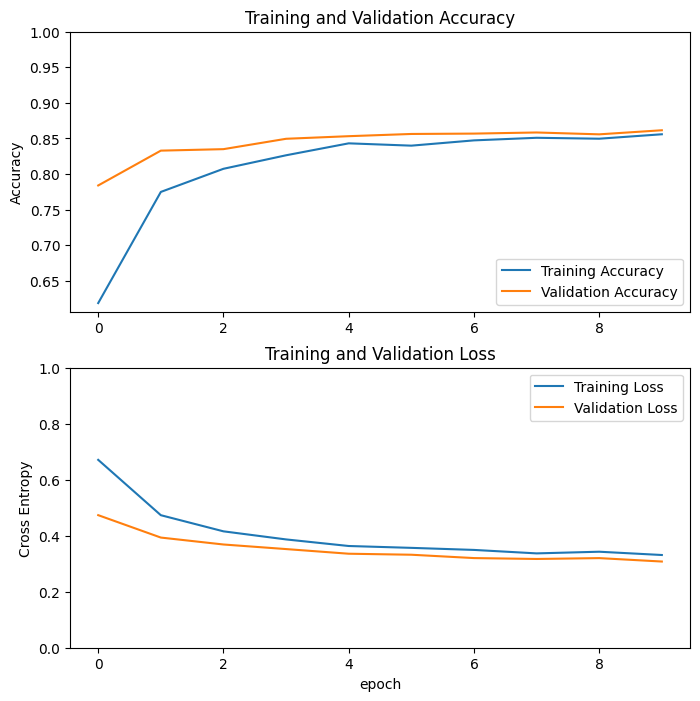

In [143]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Evaluate model

In [144]:
model.evaluate(test_dataset)

32/32 [==============================] - 7s 206ms/step - loss: 0.3026 - accuracy: 0.8680 - auc: 0.9415


[0.3026438057422638, 0.8679999709129333, 0.9415299892425537]

Predictions:
 [1 0 0 1 1 0 1 0 1 0 1 1 1 0 0 0 1 0 0 0 1 1 1 0 0 1 0 0 1 0 1 0]
Labels:
 [1 0 0 1 1 0 1 0 1 0 1 1 1 0 0 1 1 0 1 1 1 1 1 1 0 1 1 0 1 0 1 1]


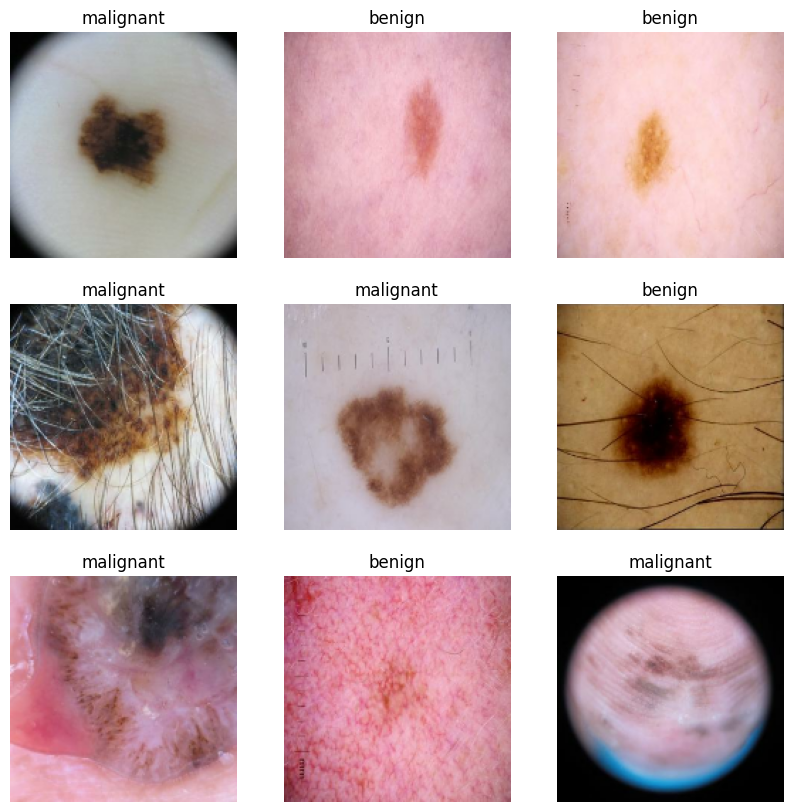

In [209]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
#predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

# Save

In [210]:
model.save('melanoma_cancer_model.h5')


c:\Users\dor\Documents\personal_projects\EveryOtherFreckle\.conda\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Publish to huggingface

In [2]:
! pip install huggingface-hub

In [4]:
import os
from huggingface_hub import (
    create_repo,
    get_full_repo_name,
    upload_file,
    delete_repo,
)

In [7]:
os.environ["HF_TOKEN"] = "XXXXXXXXXXXXXXXXXXXXXXXX" # Dont forget to remove the token before sharing the notebook.

In [73]:
# Delete the repository if it exists
# delete_repo(repo_id="<HF_USERNAME>/EveryOtherFreckle", repo_type="space")


In [12]:


target_space_name = "EveryOtherFreckle"
hf_token = os.environ["HF_TOKEN"]

# Create a new repository on HF Hub
create_repo(target_space_name, token=hf_token, repo_type="space", space_sdk="gradio")
# Get full repo name
repo_name = get_full_repo_name(model_id=target_space_name, token=hf_token)
repo_name


'Dor-Hac/EveryOtherFreckle'

In [13]:
# Upload files to repository

# gradio app file
file_url = upload_file(
    path_or_fileobj="app.py",
    path_in_repo="app.py",
    repo_id=repo_name,
    repo_type="space",
    token=hf_token,
)

# pip requirements file
file_url = upload_file(
    path_or_fileobj="requirements.txt",
    path_in_repo="requirements.txt",
    repo_id=repo_name,
    repo_type="space",
    token=hf_token,
)

# model file
file_url = upload_file(
    path_or_fileobj="melanoma_cancer_model.h5",
    path_in_repo="melanoma_cancer_model.h5",
    repo_id=repo_name,
    repo_type="space",
    token=hf_token,
)